In [1]:
import numpy as np
import pandas as pd
import openturns as ot
import openturns.viewer as viewer
import math
from matplotlib import pylab as plt
import scipy
import sys
import subprocess
import re

In [2]:
import modelib

In [3]:
#fp = 'small_ints.txt'
# for histogram in openturns, don't give counts
# give raw sizes
fp = 'intron.txt'
introns = modelib.read_txt_seqs(fp)
test = 'small_ints.txt'
# 0 is intcount_bins, 1 is intfreq_bins, 2 is intsizes, 3 is intfreqs
data = modelib.get_exinbins(introns, 500, 5)[2]
print(min(data))

38


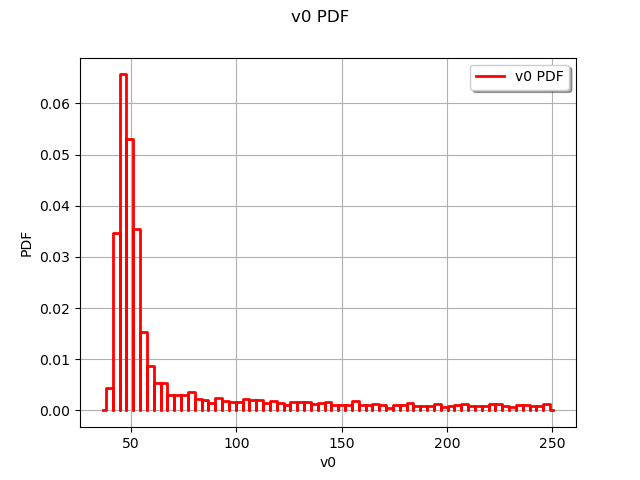

In [4]:
sample = ot.Sample([[x] for x in data if x < 250])
ot.HistogramFactory().build(sample).drawPDF()

In [5]:
# code from:
# https://openturns.github.io/openturns/latest/auto_data_analysis/distribution_fitting/plot_fit_extreme_value_distribution.html#sphx-glr-auto-data-analysis-distribution-fitting-plot-fit-extreme-value-distribution-py

In [6]:
# this may explain pdfs
# https://plotly.com/chart-studio-help/histogram/
# https://www.statisticshowto.com/extreme-value-distribution/

In [7]:
myDistribution = ot.GeneralizedExtremeValueFactory().buildAsGeneralizedExtremeValue(sample)
print(myDistribution)
print(myDistribution.getActualDistribution())

GeneralizedExtremeValue(mu=48.9091, sigma=9.01616, xi=0.780182)
Frechet(beta = 11.5565, alpha = 1.28175, gamma = 37.3526)


WRN - TNC went to an abnormal point x=[-nan,-nan,-nan] y=[] msg=TNC got a nan input value


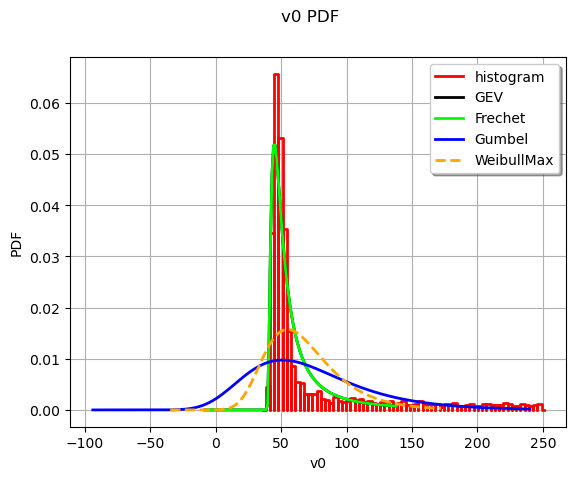

In [8]:
# code from:
# https://openturns.github.io/openturns/latest/auto_data_analysis/distribution_fitting/plot_fit_extreme_value_distribution.html#sphx-glr-auto-data-analysis-distribution-fitting-plot-fit-extreme-value-distribution-py
graph = ot.HistogramFactory().build(sample).drawPDF()
graph.add(myDistribution.drawPDF())

# distFrechet is same as myDistribution.getActualDistribution()
distFrechet = ot.FrechetFactory().buildAsFrechet(sample)
graph.add(distFrechet.drawPDF())

distGumbel = ot.GumbelFactory().buildAsGumbel(sample)
graph.add(distGumbel.drawPDF())

distWeibullMax = ot.WeibullMaxFactory().buildAsWeibullMax(sample)
curveWeibullMax = distWeibullMax.drawPDF().getDrawable(0)
curveWeibullMax.setLineStyle("dashed")
graph.add(curveWeibullMax)

graph.setColors(["red", "black", "green", "blue", "orange"])
graph.setLegends(["histogram", "GEV", "Frechet", "Gumbel", "WeibullMax"])
graph.setLegendPosition("topright")

view = viewer.View(graph)

In [9]:
a = distFrechet.getAlpha()
b = distFrechet.getBeta()
y = distFrechet.getGamma()
print(a, b, y)

1.2817516041268533 11.556474450163527 37.35258251498587


In [10]:
# goodness of fit?
# https://openturns.github.io/openturns/latest/auto_data_analysis/statistical_tests/plot_fitted_distribution_ranking.html#sphx-glr-auto-data-analysis-statistical-tests-plot-fitted-distribution-ranking-py
# https://stackoverflow.com/questions/57354430/goodness-of-fit-test-for-weibull-distribution-in-python
# https://openturns.github.io/openturns/latest/auto_data_analysis/statistical_tests/plot_kolmogorov_statistics.html


In [11]:
# maybe?
# p-value very low
# parameters are found using sample data, so fit would be good anyways?
ot.FittingTest.Kolmogorov(sample, distFrechet, 0.01)

class=TestResult name=Unnamed type=Kolmogorov Frechet binaryQualityMeasure=false p-value threshold=0.01 p-value=1.69598e-69 statistic=0.104625 description=[Frechet(beta = 11.5565, alpha = 1.28175, gamma = 37.3526) vs sample Unnamed]

In [12]:
ot.FittingTest.Kolmogorov(sample, distGumbel, 0.01)

class=TestResult name=Unnamed type=Kolmogorov Gumbel binaryQualityMeasure=false p-value threshold=0.01 p-value=0 statistic=0.268612 description=[Gumbel(beta = 37.7721, gamma = 50.8423) vs sample Unnamed]

In [13]:
# https://openturns.github.io/openturns/latest/user_manual/_generated/openturns.Frechet.html

In [14]:
def frechet_pdf(x, a, b, y):
    if x < y: return 0
    z = (x-y)/b
    term1 = (a/b)
    term2 = z**(-1-a)
    term3 = math.exp(-z**-a)
    return term1 * term2 * term3
    
# can change minimum x with y    
print(frechet_pdf(37, 1.28, 11.56, 30.35))
print(frechet_pdf(35, a, b, y))
print(frechet_pdf(100, a, b, y))

0.051332438692224515
0
0.002090429163827152


In [15]:
x_values = []
y_values = []
y_scores = []
for i in range(50):
    x_values.append(i)
    y = frechet_pdf(i, 1.28, 11.56, 37.35)
    y_values.append(y)
    if y == 0: y_scores.append(-99)
    else: y_scores.append(math.log2(y))

In [16]:
x_values = []
y_values = []
introns = modelib.read_txt_seqs('small_ints.txt')
yscores, yvalues = modelib.memoize_fdist(introns, pre2=6)
for i in range(len(yvalues)):
    x_values.append(i)
    y_values.append(yvalues[i])
print(y_values)
print(x_values)

['0.000000', '0.000000', '0.000000', '0.006121', '0.138788', '0.213532', '0.178837', '0.127404', '0.087589', '0.060524', '0.042597']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


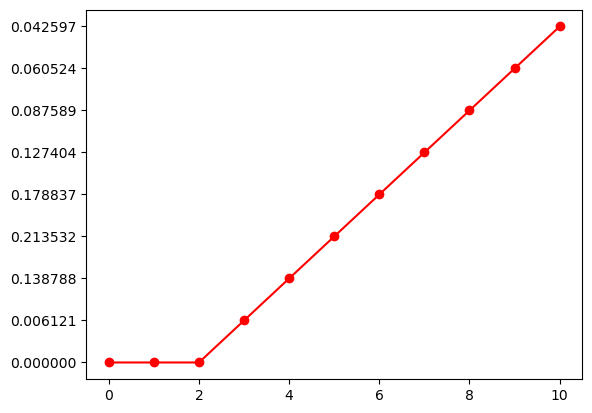

In [17]:
fig, ax = plt.subplots()
ax.plot(x_values, y_values, "or-")
plt.show()
# idk how to fix this

In [18]:
data = {
    'x': x_values,
    'y': y_values
}

df = pd.DataFrame(data)
df

,x,y
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.006121
4,4,0.138788
5,5,0.213532
6,6,0.178837
7,7,0.127404
8,8,0.087589
9,9,0.060524


<Axes: xlabel='x', ylabel='y'>

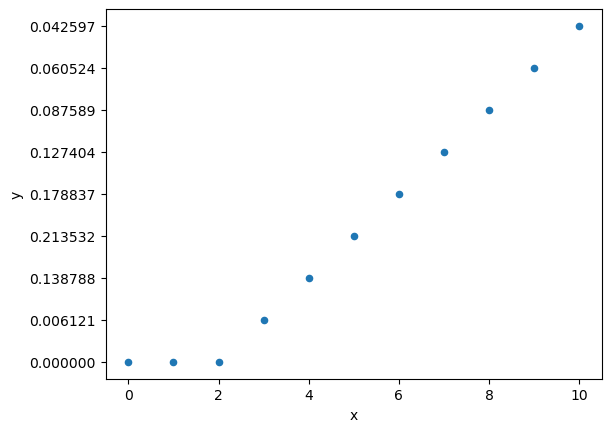

In [19]:
df.plot(x='x', y='y', kind='scatter')